<a href="https://colab.research.google.com/github/maddy1096/CryptocurrencyPredictionAndAnalysis/blob/main/LSTM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

Getting the data

In [3]:
import requests
import json
import pandas as pd
import datetime
import csv
def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=1, aggregate=1, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
  
    return df

x = ['BTC']
for i in x:
  m = daily_price_historical(i,'USD')
  m['Symbol'] = i
  m.to_csv("./{0}_price.csv".format(i.replace("-","_")),index = False)

  print('Dataset of '+i+' has been created')

Dataset of BTC has been created


Preprocessing the data

3157 790


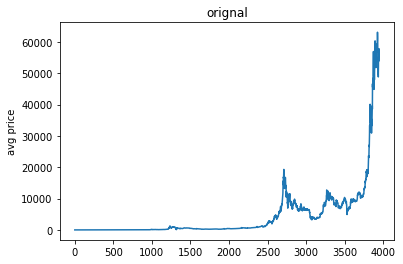

In [4]:
dataset_train = pd.read_csv('BTC_price.csv')



high = dataset_train.loc[:,'high'].to_numpy()
low_prices = dataset_train.loc[:,'low'].to_numpy()
mid_prices = (high+low_prices)/2.0
dataset_train['mid'] = mid_prices

training_set = dataset_train.iloc[:,-1].values

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set = training_set.reshape(-1,1)
training_set_scaled = sc.fit_transform(training_set)

train_size = int(len(training_set_scaled) * 0.80)
test_size = len(training_set_scaled) - train_size
train, test = training_set_scaled[0:train_size,:], training_set_scaled[train_size:len(training_set_scaled),:]
print(len(train), len(test))
plt.title('orignal')
plt.ylabel('avg price')
plt.plot(training_set)
plt.show()

In [5]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Building the model

In [6]:
#Step 2 Build Model


model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print ('compilation time : ', time.time() - start)

model.fit(
    trainX,
    trainY,
    batch_size=110,
    epochs=100,
    validation_split=0.05)

compilation time :  0.011088132858276367
Epoch 1/100
28/28 [==============================] - 3s 36ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 8.5440e-04 - val_loss: 7.7259e-04
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 5.0065e-04 - val_loss: 3.7426e-04
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 2.5462e-04 - val_loss: 1.6781e-04
Epoch 8/100
28/28 [==============================] - 0s 5ms/step - loss: 1.0866e-04 - val_loss: 6.4973e-05
Epoch 9/100
28/28 [==============================] - 0s 5ms/step - loss: 3.4879e-05 - val_loss: 2.0368e-05
Epoch 10/100
28/28 [=======

[[0.06184538]]
[[0.10596474]]
[[0.18187945]]
[[0.31338885]]
[[0.5419592]]
[[0.9375574]]
[[1.6037328]]
[[2.628007]]
[[3.903676]]
[[5.059437]]
[[  3901.6482]
 [  6684.9775]
 [ 11474.158 ]
 [ 19770.607 ]
 [ 34190.277 ]
 [ 59147.12  ]
 [101173.695 ]
 [165791.4   ]
 [246268.7   ]
 [319181.44  ]]


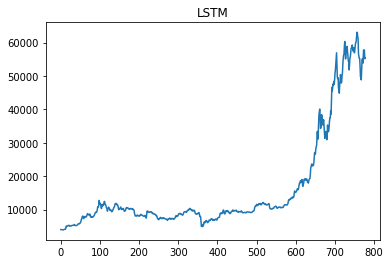

In [7]:

def plot_results_multiple(predicted_data, true_data,length):
   
    plt.plot(sc.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(sc.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.title("LSTM")
    plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=10
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(sc.inverse_transform(np.array(predictions).reshape(-1, 1)))

plot_results_multiple(predictions, testY, predict_length,)


Calculate MSE

In [8]:
y_pred = model.predict(testX)
model.evaluate(testX,testY)



25/25 [==============================] - 0s 1ms/step - loss: 1.3992e-04


0.0001399247266817838